# 1. ResNet-50 - Transfer learning (non trainable)
In this model we use the ResNet-50 structure with including the weights of 'imagenet', which are made non trainable except the last layer.

## 1.1 Import libaries, general functions and global variables

### 1.1.1 Libaries

In [2]:
# Import all the libaris in the module dependencies
from dependencies import *

### 1.1.2 General functions

In [3]:
# Import some general functions created by myself (loading the data, visualizing conv layers, etc.)
from general_functions import *

### 1.1.3 Global variables

In [4]:
dataset_path = os.path.join(os.getcwd(), 'datasets', 'UTKface_cropped-new-structure-balanced')

In [5]:
training_path   = os.path.join(os.getcwd(), 'datasets', 'UTKface_cropped-new-structure-balanced', 'training')
validation_path = os.path.join(os.getcwd(), 'datasets', 'UTKface_cropped-new-structure-balanced', 'validation')
test_path       = os.path.join(os.getcwd(), 'datasets', 'UTKface_cropped-new-structure-balanced', 'test')

In [6]:
df = load_dataset('df-UTKface_cropped-balanced.pkl')
df.head()

,age,age-binned,gender,race,datetime,category,path
0,10,"(0, 10]",0,0,20161220222308131,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_cropped-new-structure-balanced\training\10
1,10,"(0, 10]",0,0,20170103200329407,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_cropped-new-structure-balanced\training\10
2,10,"(0, 10]",0,0,20170103200522151,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_cropped-new-structure-balanced\training\10
3,10,"(0, 10]",0,0,20170103233459275,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_cropped-new-structure-balanced\training\10
4,10,"(0, 10]",0,0,20170104013211746,training,C:\Users\Paulo\Documents\GitHub\deep-learning-age-estimation\notebooks\datasets\UTKface_cropped-new-structure-balanced\training\10


In [7]:
df['age-binned'].value_counts()

(60, 70]    1170
(50, 60]    1170
(40, 50]    1170
(30, 40]    1170
(20, 30]    1170
(10, 20]    1170
(0, 10]     1170
Name: age-binned, dtype: int64

## 1.2 Generator

In [8]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (224, 224) # We replicate the 224 x 224 shape like the paper.
COLOR_MODE  = 'rgb'      # Model ResNet-50 will expect rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE,
                                                      shuffle      = False)

Found 6177 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.
Found 384 images belonging to 7 classes.


<br>

## 1.3 Import ResNet-50 (including weights) and add output layer with 7 nodes

In [8]:
TARGET_SIZE_WITH_DIMENSIONS = list(TARGET_SIZE)
TARGET_SIZE_WITH_DIMENSIONS.append(3)
TARGET_SIZE_WITH_DIMENSIONS = tuple(TARGET_SIZE_WITH_DIMENSIONS)

model = keras.applications.resnet.ResNet50(include_top = False, 
                                           weights     = 'imagenet',  
                                           input_shape = TARGET_SIZE_WITH_DIMENSIONS,
                                           classes     = 7)


94773248/94765736 [==============================] - 9s 0us/step


In [9]:
# Freeze everything from the ResNet-50 model
for layer in model.layers:
    layer.trainable = False

In [10]:
# Adding GlobalAveragePooling2D and an output layer
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# Add compiler
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

<br>

## 1.4 Run the model

In [12]:
filepath = "models-and-results-UTKface_cropped-balanced/resnet-50-1.0-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              callbacks           = callbacks_list,
                              workers             = (multiprocessing.cpu_count())
                             )


Epoch 1/15
193/193 [==============================] - 1917s 10s/step - loss: 1.5525 - accuracy: 0.3867 - val_loss: 2.5218 - val_accuracy: 0.1331

Epoch 00001: val_accuracy improved from -inf to 0.13313, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-1.0-0.13.h5
Epoch 2/15
193/193 [==============================] - 1847s 10s/step - loss: 1.2730 - accuracy: 0.5011 - val_loss: 2.6089 - val_accuracy: 0.1140

Epoch 00002: val_accuracy did not improve from 0.13313
Epoch 3/15
193/193 [==============================] - 2004s 10s/step - loss: 1.1894 - accuracy: 0.5318 - val_loss: 2.8322 - val_accuracy: 0.1390

Epoch 00003: val_accuracy improved from 0.13313 to 0.13901, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-1.0-0.14.h5
Epoch 4/15
193/193 [==============================] - 1906s 10s/step - loss: 1.1204 - accuracy: 0.5598 - val_loss: 3.2480 - val_accuracy: 0.1259

Epoch 00004: val_accuracy did not improve from 0.13901
Epoch 5/15
193/193 [====

## 1.5 Save the results

In [13]:
# Save results
model.save('models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-1.0-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-resnet-50-1.0-history', 
                   storage_location = 'models-and-results-UTKface_cropped-balanced')

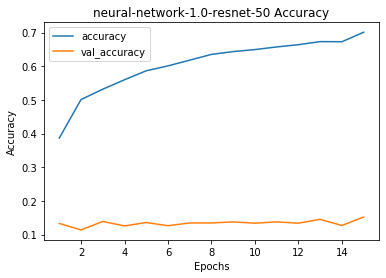

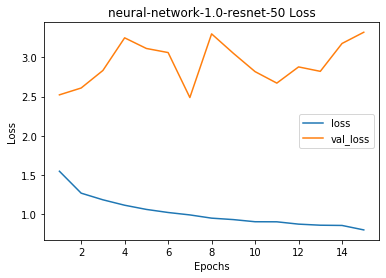

In [14]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-1.0-resnet-50 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-1.0-resnet-50 Loss')

Predictions: [[8.0537081e-01 1.9393052e-01 6.9511170e-04 3.3857643e-06 7.2045395e-08
  6.2656831e-08 2.7418098e-08]].
conv2_block1_1_bn_3 (1, 56, 56, 64) 


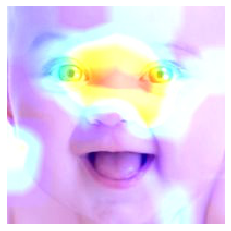

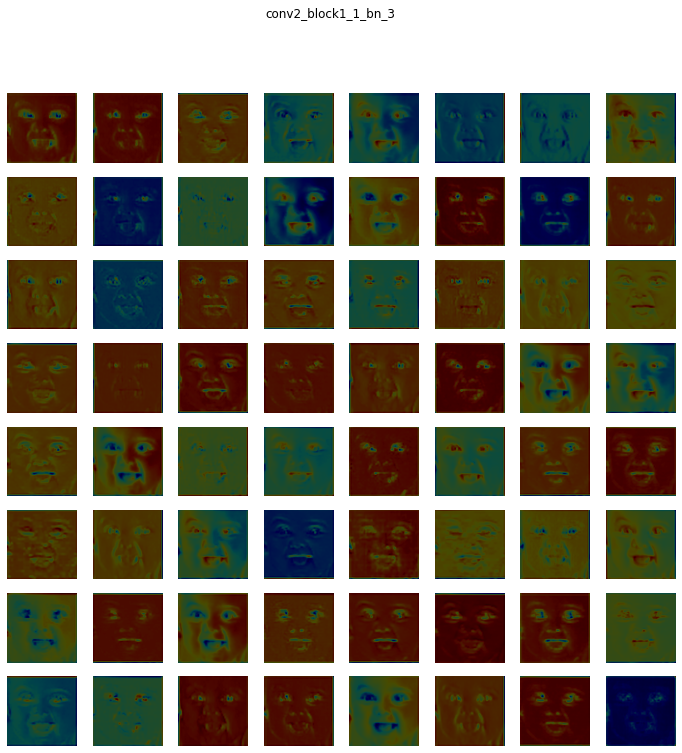

In [8]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-1.0-0.15.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-1.0-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg')

plot_layers(model_path         = model_path,
            best_val_score     = best_val_score,
            img_path           = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg',
            target_size_img    = (224, 224),
            color_mode_img     = 'rgb')

Predictions: [[2.2245687e-03 5.6278318e-01 2.2838943e-01 1.6277167e-01 3.4871280e-02
  8.9570777e-03 2.8122467e-06]].


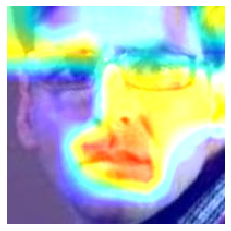

In [49]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\40\31_0_3_20170104230610969.jpg.chip.jpg')

Predictions: [[3.8659513e-02 7.3504484e-01 6.4316705e-02 2.7713513e-02 5.2352414e-02
  8.1770271e-02 1.4285148e-04]].


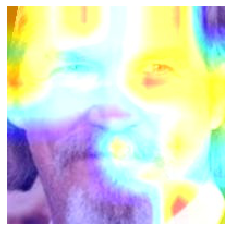

In [50]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\70\65_0_0_20170120222348112.jpg.chip.jpg')

Mean class accuracies:

Class 1-10 has an accuracy of 0.0.
Class 11-20 has an accuracy of 0.0.
Class 21-30 has an accuracy of 1.0.
Class 31-40 has an accuracy of 0.0.
Class 41-50 has an accuracy of 0.0.
Class 51-60 has an accuracy of 0.0.
Class 61-70 has an accuracy of 0.0.


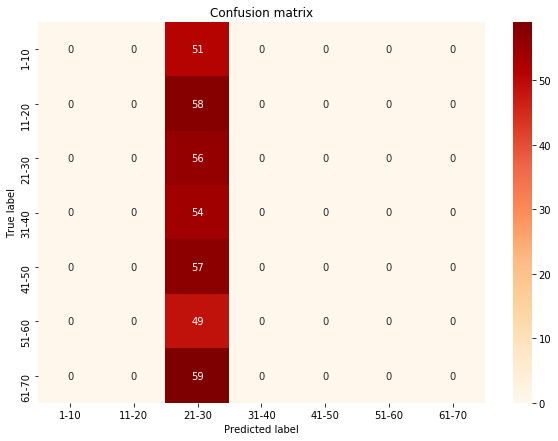

In [10]:
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-1.0-0.15.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-1.0-model.h5'

plot_confusion_matrix(model_path, best_val_score, test_generator)

<br><br><br><br><br><br><br><br>

# 2. ResNet-50 - Retrain ResNet-50 structure + own output layer

## 2.1 Generator

In [11]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (224, 224) # We replicate the 224 x 224 shape like the paper.
COLOR_MODE  = 'rgb'      # Model ResNet-50 will expect rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE,
                                                      shuffle      = False)

Found 6177 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.
Found 384 images belonging to 7 classes.


<br>

## 2.2 Import ResNet-50 stucture and add global averge pooling and output layer

In [22]:
TARGET_SIZE_WITH_DIMENSIONS = list(TARGET_SIZE)
TARGET_SIZE_WITH_DIMENSIONS.append(3)
TARGET_SIZE_WITH_DIMENSIONS = tuple(TARGET_SIZE_WITH_DIMENSIONS)

model = keras.applications.resnet.ResNet50(include_top = False, 
                                           weights     = None,  
                                           input_shape = TARGET_SIZE_WITH_DIMENSIONS)

In [23]:
# Adding GlobalAveragePooling2D and an output layer
x = model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x) # Could add dropout layer
predictions = Dense(7, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# Add compiler
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [24]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

<br>

## 2.3 Run the model

In [25]:
filepath = "models-and-results-UTKface_cropped-balanced/resnet-50-2.0-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              callbacks           = callbacks_list,
                              workers             = (multiprocessing.cpu_count())
                             )

Epoch 1/15
193/193 [==============================] - 5352s 28s/step - loss: 1.9604 - accuracy: 0.2880 - val_loss: 1.9540 - val_accuracy: 0.1975

Epoch 00001: val_accuracy improved from -inf to 0.19750, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-2.0-0.20.h5
Epoch 2/15
193/193 [==============================] - 5363s 28s/step - loss: 1.7146 - accuracy: 0.3349 - val_loss: 60.1234 - val_accuracy: 0.1797

Epoch 00002: val_accuracy did not improve from 0.19750
Epoch 3/15
193/193 [==============================] - 5367s 28s/step - loss: 1.5741 - accuracy: 0.3731 - val_loss: 1.5195 - val_accuracy: 0.3118

Epoch 00003: val_accuracy improved from 0.19750 to 0.31183, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-2.0-0.31.h5
Epoch 4/15
193/193 [==============================] - 5574s 29s/step - loss: 1.4028 - accuracy: 0.4366 - val_loss: 2.0324 - val_accuracy: 0.3826

Epoch 00004: val_accuracy improved from 0.31183 to 0.38259, saving model to mod

## 2.4 Save the results

In [26]:
# Save results
model.save('models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-2.0-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-resnet-50-2.0-history', 
                   storage_location = 'models-and-results-UTKface_cropped-balanced')

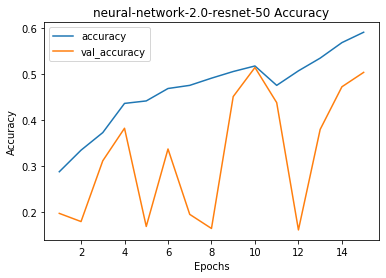

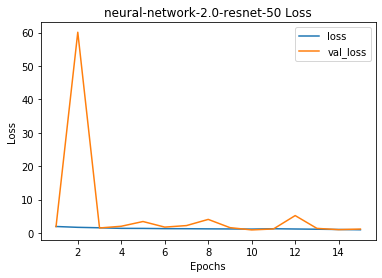

In [27]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-2.0-resnet-50 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-2.0-resnet-50 Loss')

Predictions: [[1. 0. 0. 0. 0. 0. 0.]].
conv2_block1_1_bn_5 (1, 56, 56, 64) 


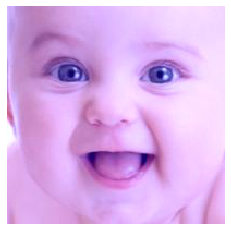

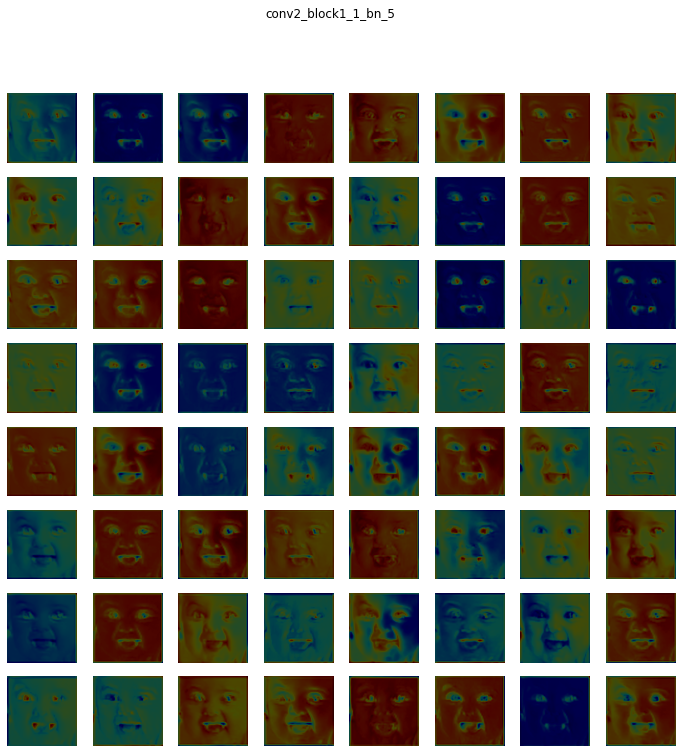

In [9]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-2.0-0.51.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-2.0-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg')

plot_layers(model_path         = model_path,
            best_val_score     = best_val_score,
            img_path           = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg',
            target_size_img    = (224, 224),
            color_mode_img     = 'rgb')

Predictions: [[1. 0. 0. 0. 0. 0. 0.]].


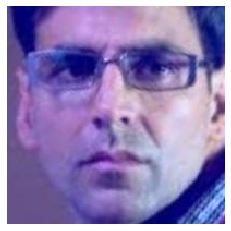

In [30]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\40\31_0_3_20170104230610969.jpg.chip.jpg')

Predictions: [[1. 0. 0. 0. 0. 0. 0.]].


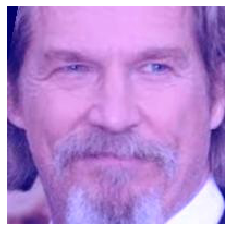

In [31]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\70\65_0_0_20170120222348112.jpg.chip.jpg')

Mean class accuracies:

Class 1-10 has an accuracy of 0.86.
Class 11-20 has an accuracy of 0.64.
Class 21-30 has an accuracy of 0.54.
Class 31-40 has an accuracy of 0.65.
Class 41-50 has an accuracy of 0.3.
Class 51-60 has an accuracy of 0.31.
Class 61-70 has an accuracy of 0.42.


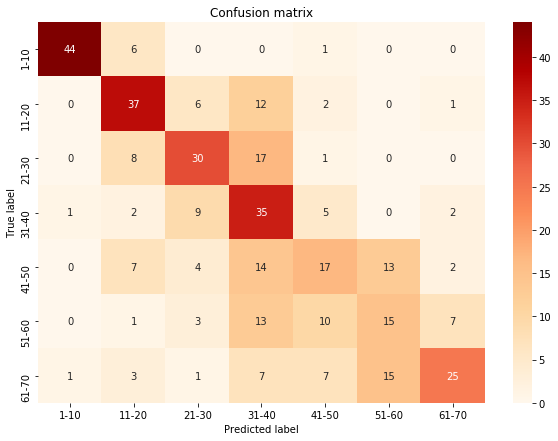

In [12]:
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-2.0-0.51.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-2.0-model.h5'

plot_confusion_matrix(model_path, best_val_score, test_generator)

<br><br><br><br><br>
# 3. ResNet-50 - Transfer learning with trainable weights
In this model we use the ResNet-50 structure with including the weights of 'imagenet', which we make trainable. We also add our own output layer of 7 nodes.

## 3.1 Generator

In [13]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (224, 224) # We replicate the 224 x 224 shape like the paper.
COLOR_MODE  = 'rgb'      # Model ResNet-50 will expect rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE,
                                                      shuffle      = False)

Found 6177 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.
Found 384 images belonging to 7 classes.


<br>

## 3.2 Import ResNet-50 (including weights) and add output layer with 7 nodes

In [9]:
TARGET_SIZE_WITH_DIMENSIONS = list(TARGET_SIZE)
TARGET_SIZE_WITH_DIMENSIONS.append(3)
TARGET_SIZE_WITH_DIMENSIONS = tuple(TARGET_SIZE_WITH_DIMENSIONS)

model = keras.applications.resnet.ResNet50(include_top = False, 
                                           weights     = 'imagenet',  
                                           input_shape = TARGET_SIZE_WITH_DIMENSIONS)

In [10]:
# Adding GlobalAveragePooling2D and an output layer
x = model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# Add compiler
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

<br>

## 3.3 Run the model

In [53]:
filepath = "models-and-results-UTKface_cropped-balanced/resnet-50-3.0-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              callbacks           = callbacks_list,
                              workers             = (multiprocessing.cpu_count())
                             )

Epoch 1/15
193/193 [==============================] - 362s 2s/step - loss: 1.4391 - accuracy: 0.4330 - val_loss: 9.5312 - val_accuracy: 0.1381

Epoch 00001: val_accuracy improved from -inf to 0.13813, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-3.0-0.14.h5
Epoch 2/15
193/193 [==============================] - 350s 2s/step - loss: 1.0746 - accuracy: 0.5531 - val_loss: 3.8594 - val_accuracy: 0.1490

Epoch 00002: val_accuracy improved from 0.13813 to 0.14903, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-3.0-0.15.h5
Epoch 3/15
193/193 [==============================] - 345s 2s/step - loss: 1.0653 - accuracy: 0.5604 - val_loss: 2.4037 - val_accuracy: 0.1478

Epoch 00003: val_accuracy did not improve from 0.14903
Epoch 4/15
193/193 [==============================] - 347s 2s/step - loss: 0.9233 - accuracy: 0.6161 - val_loss: 3.9981 - val_accuracy: 0.1678

Epoch 00004: val_accuracy improved from 0.14903 to 0.16781, saving model to models-and-r

## 3.4 Save the results

In [ ]:
# Save results
model.save('models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-3.0-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-resnet-50-3.0-history', 
                   storage_location = 'models-and-results-UTKface_cropped-balanced')

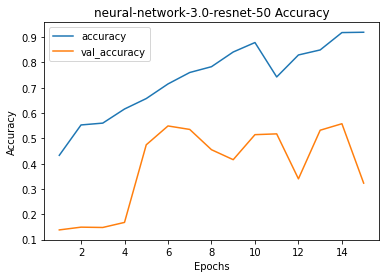

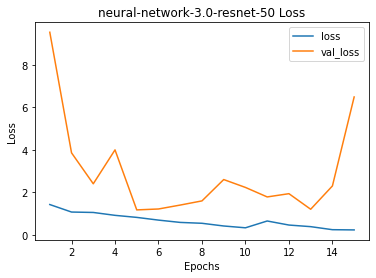

In [55]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-3.0-resnet-50 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-3.0-resnet-50 Loss')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].
conv2_block1_1_bn_7 (1, 56, 56, 64) 


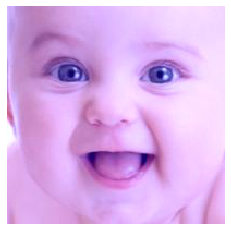

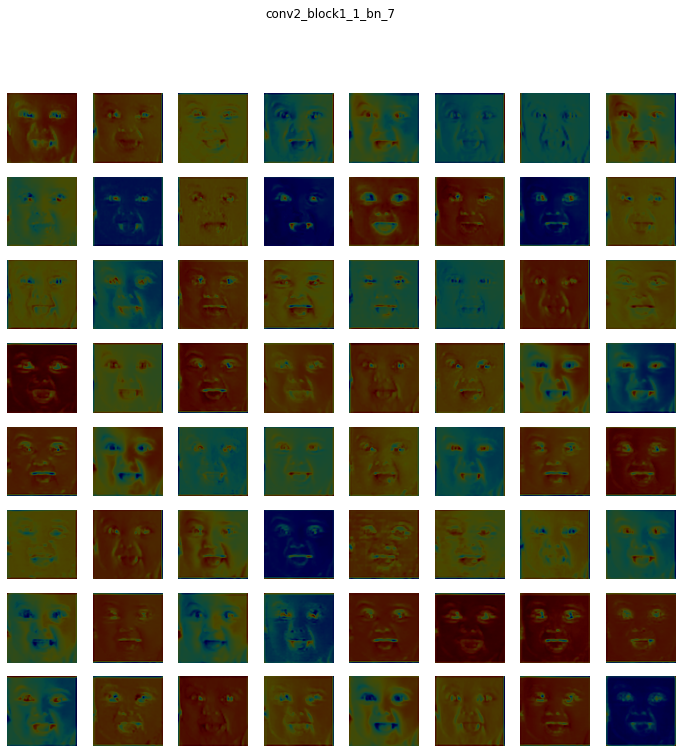

In [10]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-3.0-0.55.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-3.0-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg')

plot_layers(model_path         = model_path,
            best_val_score     = best_val_score,
            img_path           = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg',
            target_size_img    = (224, 224),
            color_mode_img     = 'rgb')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].


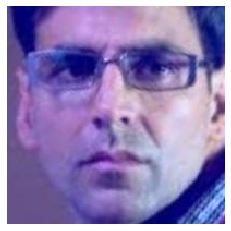

In [14]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\40\31_0_3_20170104230610969.jpg.chip.jpg')

Predictions: [[0. 0. 1. 0. 0. 0. 0.]].


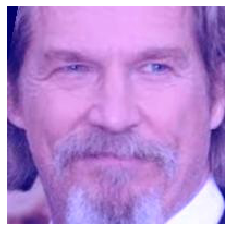

In [15]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\70\65_0_0_20170120222348112.jpg.chip.jpg')

Mean class accuracies:

Class 1-10 has an accuracy of 0.88.
Class 11-20 has an accuracy of 0.62.
Class 21-30 has an accuracy of 0.23.
Class 31-40 has an accuracy of 0.69.
Class 41-50 has an accuracy of 0.37.
Class 51-60 has an accuracy of 0.2.
Class 61-70 has an accuracy of 0.63.


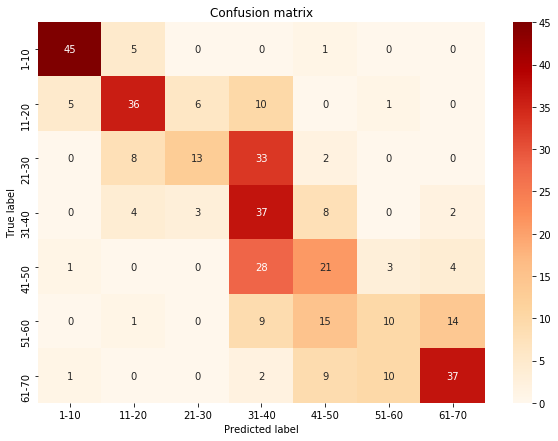

In [14]:
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-3.0-0.55.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-3.0-model.h5'

plot_confusion_matrix(model_path, best_val_score, test_generator)

<br><br><br><br>


# 4. ResNet-50 - Transfer learning (non trainable) + 3 extra layers
In this model we use the ResNet-50 structure with including the weights of 'imagenet', which are made non trainable except the last layers.

## 4.2 Generator

In [15]:
# Define image generators objects
train_datagen      = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen       = ImageDataGenerator(rescale=1./255)

# Create image generators
TARGET_SIZE = (224, 224) # We replicate the 224 x 224 shape like the paper.
COLOR_MODE  = 'rgb'      # Model ResNet-50 will expect rgb
BATCH_SIZE  = 32

train_generator    = train_datagen.flow_from_directory(directory   = training_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

validation_datagen = train_datagen.flow_from_directory(directory   = validation_path,
                                                       target_size = TARGET_SIZE,
                                                       color_mode  = COLOR_MODE,
                                                       batch_size  = BATCH_SIZE)

test_generator     = test_datagen.flow_from_directory(directory    = test_path,
                                                      target_size  = TARGET_SIZE,
                                                      color_mode   = COLOR_MODE,
                                                      batch_size   = BATCH_SIZE,
                                                      shuffle      = False)

Found 6177 images belonging to 7 classes.
Found 1629 images belonging to 7 classes.
Found 384 images belonging to 7 classes.


<br>

## 4.3 Import ResNet-50 (including weights) and add three dense layers (512, 512, output 7)

In [21]:
TARGET_SIZE_WITH_DIMENSIONS = list(TARGET_SIZE)
TARGET_SIZE_WITH_DIMENSIONS.append(3)
TARGET_SIZE_WITH_DIMENSIONS = tuple(TARGET_SIZE_WITH_DIMENSIONS)

model = keras.applications.resnet.ResNet50(include_top = False, 
                                           weights     = 'imagenet',  
                                           input_shape = TARGET_SIZE_WITH_DIMENSIONS)

In [22]:
# Freeze everything from the ResNet-50 model
for layer in model.layers:
    layer.trainable = False

In [23]:
# Adding GlobalAveragePooling2D and an output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation= 'relu')(x)
x = Dense(512, activation= 'relu')(x)
predictions = Dense(7, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# Add compiler
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [24]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

<br>

## 4.4 Run the model

In [42]:
filepath = "models-and-results-UTKface_cropped-balanced/resnet-50-4.0-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator           = train_generator,
                              steps_per_epoch     = train_generator.n // train_generator.batch_size,
                              epochs              = 15,
                              validation_data     = validation_datagen,
                              validation_steps    = validation_datagen.n // validation_datagen.batch_size,
                              verbose             = 1,
                              callbacks           = callbacks_list
                             )

Epoch 1/15
193/193 [==============================] - 120s 621ms/step - loss: 1.4482 - accuracy: 0.4244 - val_loss: 2.6932 - val_accuracy: 0.1375

Epoch 00001: val_accuracy improved from -inf to 0.13750, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-4.0-0.14.h5
Epoch 2/15
193/193 [==============================] - 117s 608ms/step - loss: 1.1981 - accuracy: 0.5032 - val_loss: 2.5232 - val_accuracy: 0.1409

Epoch 00002: val_accuracy improved from 0.13750 to 0.14089, saving model to models-and-results-UTKface_cropped-balanced/resnet-50-4.0-0.14.h5
Epoch 3/15
193/193 [==============================] - 117s 607ms/step - loss: 1.1241 - accuracy: 0.5419 - val_loss: 2.9172 - val_accuracy: 0.1371

Epoch 00003: val_accuracy did not improve from 0.14089
Epoch 4/15
193/193 [==============================] - 119s 618ms/step - loss: 1.0687 - accuracy: 0.5601 - val_loss: 3.2537 - val_accuracy: 0.1353

Epoch 00004: val_accuracy did not improve from 0.14089
Epoch 5/15
193/193 [=

## 4.5 Save the results

In [ ]:
# Save results
model.save('models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-4.0-model.h5')
save_history_model(history          = history,
                   filename         = 'neural-network-resnet-50-4.0-history', 
                   storage_location = 'models-and-results-UTKface_cropped-balanced')

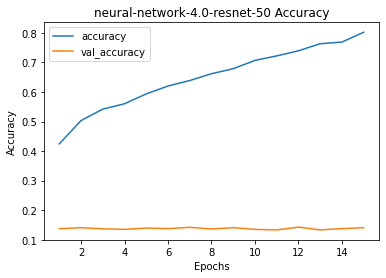

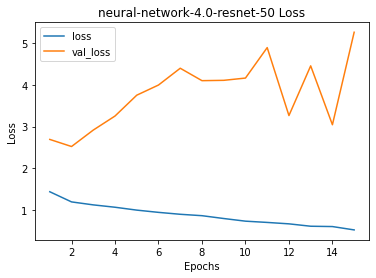

In [44]:
# Plot history
plot_history(history, line1='accuracy', line2='val_accuracy',
             x_as = 'Epochs', y_as = 'Accuracy', title = 'neural-network-4.0-resnet-50 Accuracy')

plot_history(history, line1='loss', line2='val_loss',
             x_as = 'Epochs', y_as = 'Loss', title = 'neural-network-4.0-resnet-50 Loss')

Predictions: [[9.99401212e-01 5.98570565e-04 2.54538634e-07 4.96242457e-11
  3.01448601e-12 1.44025482e-12 1.03367076e-13]].
conv2_block1_1_bn_9 (1, 56, 56, 64) 


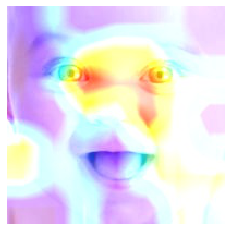

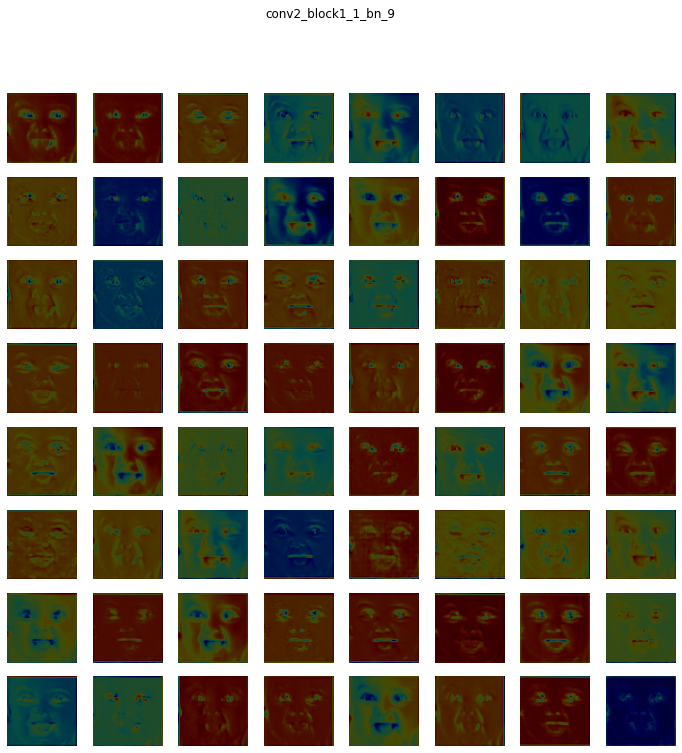

In [11]:
# Plot image activation
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-4.0-0.14.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-4.0-model.h5'

plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg')

plot_layers(model_path         = model_path,
            best_val_score     = best_val_score,
            img_path           = r'datasets\UTKface_cropped-new-structure-balanced\test\10\1_0_0_20170110212624891.jpg.chip.jpg',
            target_size_img    = (224, 224),
            color_mode_img     = 'rgb')

Predictions: [[0.0068291  0.7475287  0.08945432 0.11059687 0.03931579 0.00441426
  0.00186103]].


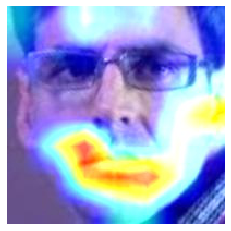

In [30]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\40\31_0_3_20170104230610969.jpg.chip.jpg')

Predictions: [[0.03150075 0.8128801  0.05501247 0.03974313 0.0396456  0.01828877
  0.00292923]].


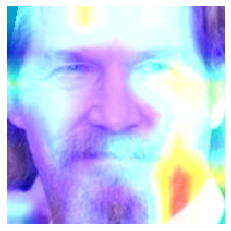

In [31]:
plot_image_activation(model_path   = model_path, 
                      weights_path = best_val_score, 
                      img_path     = r'datasets\UTKface_cropped-new-structure-balanced\test\70\65_0_0_20170120222348112.jpg.chip.jpg')

Mean class accuracies:

Class 1-10 has an accuracy of 0.0.
Class 11-20 has an accuracy of 0.0.
Class 21-30 has an accuracy of 1.0.
Class 31-40 has an accuracy of 0.0.
Class 41-50 has an accuracy of 0.0.
Class 51-60 has an accuracy of 0.0.
Class 61-70 has an accuracy of 0.0.


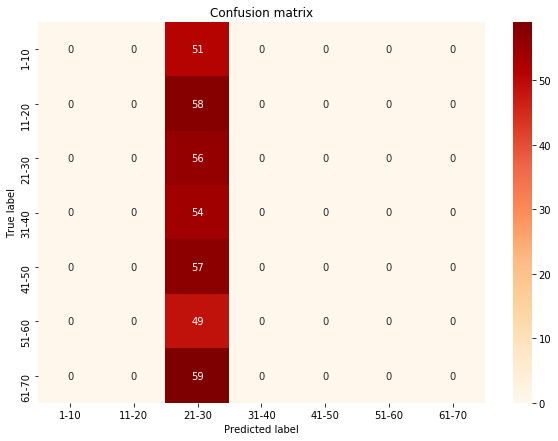

In [16]:
best_val_score = 'models-and-results-UTKface_cropped-balanced/resnet-50-4.0-0.14.h5'
model_path     = 'models-and-results-UTKface_cropped-balanced/neural-network-resnet-50-4.0-model.h5'

plot_confusion_matrix(model_path, best_val_score, test_generator)